In [1]:
# copied from https://www.kaggle.com/sohier/competition-api-detailed-introduction
import riiideducation
env = riiideducation.make_env()

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import riiideducation
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, plot_confusion_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


In [3]:
train_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv', low_memory=False, nrows=10**7, 
                       dtype={'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 'content_id': 'int16', 'content_type_id': 'int8',
                              'task_container_id': 'int16', 'user_answer': 'int8', 'answered_correctly': 'int8', 'prior_question_elapsed_time': 'float32', 
                             'prior_question_had_explanation': 'boolean',
                             }
                      )
train_df = train_df.drop(columns='row_id')
train_df = train_df.dropna()

In [4]:
def train_my_model(df):   
    content_accuracy = df.groupby('content_id').answered_correctly.mean()
    content_duration = df.groupby('content_id').prior_question_elapsed_time.mean()
    df = df.merge(content_accuracy, left_on = 'content_id',right_index=True,how='left')
    df = df.rename(columns = {'answered_correctly_y':'difficulty_rate','answered_correctly_x':'answered_correctly'})
    
    X1 = df[['difficulty_rate','prior_question_had_explanation']]
    y1 = df.loc[X1.index]['answered_correctly']
    
    X1_train, X1_test, y1_train, y1_test = train_test_split( X1, y1, test_size=.3, random_state=0 )
    
    m = LogisticRegression()
    
    true_model = m.fit(X1_train,y1_train)
    plot_confusion_matrix(m, X1_test, y1_test,cmap=plt.cm.Blues)
    print('Accuracy Score: {}'.format(accuracy_score(y1_test, m.predict(X1_test))))
    print('Recall Score: {}'.format(recall_score(y1_test, m.predict(X1_test))))
    print('Precision Score: {}'.format(precision_score(y1_test, m.predict(X1_test))))
    return true_model, df

Accuracy Score: 0.7030873184244077
Recall Score: 0.8884026564428276
Precision Score: 0.7236645005049499


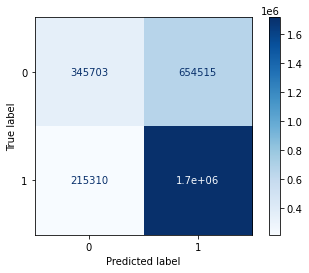

In [5]:
# Training data is in the competition dataset as usual
#train_df = pd.read_csv('/kaggle/input/riiideducation/train.csv', low_memory=False)
model, train_df = train_my_model(train_df)

In [6]:
question_df = train_df.groupby('content_id').answered_correctly.mean()
question_df

content_id
0        0.908828
1        0.893939
2        0.562444
3        0.780316
4        0.627973
           ...   
13518    0.790698
13519    0.581395
13520    0.682927
13521    0.781609
13522    0.895349
Name: answered_correctly, Length: 13500, dtype: float64

In [7]:
del train_df

In [8]:
# most barebones skeleton of submission notebook
# copied from https://www.kaggle.com/sohier/competition-api-detailed-introduction
'''
import riiideducation
env = riiideducation.make_env()

# Training data is in the competition dataset as usual
train_df = pd.read_csv('/kaggle/input/riiideducation/train.csv', low_memory=False)
train_my_model(train_df)
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    test_df['answered_correctly'] = 0.5
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])
'''

"\nimport riiideducation\nenv = riiideducation.make_env()\n\n# Training data is in the competition dataset as usual\ntrain_df = pd.read_csv('/kaggle/input/riiideducation/train.csv', low_memory=False)\ntrain_my_model(train_df)\niter_test = env.iter_test()\nfor (test_df, sample_prediction_df) in iter_test:\n    test_df['answered_correctly'] = 0.5\n    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])\n"

In [9]:
# modeling next code block off of this, from nathmart's notebook: https://www.kaggle.com/nathmart/riiid-notebook
# inserted with my own comments as I try to understand this code
'''
previous_test_df = None
for (test_df, sample_prediction_df) in iter_test:
    if previous_test_df is not None:
        previous_test_df['answered_correctly'] = eval(test_df["prior_group_answers_correct"].iloc[0])
            # eval is a function that takes a string(?) and runs/evaluates it
            # ex. eval('1+1') returns 2
        update_user_feats(previous_test_df, answered_correctly_sum_u_dict, count_u_dict)
    previous_test_df = test_df.copy()
    test_df = test_df.merge(content_df, on = "content_id", how = "left")
    test_df = test_df.merge(questions[["content_id", "part"]], on = "content_id", how = "left")
    test_df = add_user_feats_without_update(test_df, answered_correctly_sum_u_dict, count_u_dict)
    test_df['content_questions'].fillna(0, inplace = True)
    test_df['content_mean'].fillna(0.5, inplace = True)
    test_df['count_u'].fillna(0, inplace = True)
    test_df['answered_correctly_sum_u'].fillna(0, inplace = True)
    test_df['answered_correctly_avg_u'].fillna(0.5, inplace = True)
    test_df['prior_question_elapsed_time'].fillna(mean_prior, inplace = True)
    test_df['prior_question_had_explanation'].fillna(False, inplace = True)
    test_df['prior_question_had_explanation'] = label_enc.transform(test_df['prior_question_had_explanation'])
    test_df[['content_questions', 'count_u']] = test_df[['content_questions', 'count_u']].astype(int)
    test_df['answered_correctly'] =  model.predict(test_df[features])
    set_predict(test_df[['row_id', 'answered_correctly']])
'''

'\nprevious_test_df = None\nfor (test_df, sample_prediction_df) in iter_test:\n    if previous_test_df is not None:\n        previous_test_df[\'answered_correctly\'] = eval(test_df["prior_group_answers_correct"].iloc[0])\n            # eval is a function that takes a string(?) and runs/evaluates it\n            # ex. eval(\'1+1\') returns 2\n        update_user_feats(previous_test_df, answered_correctly_sum_u_dict, count_u_dict)\n    previous_test_df = test_df.copy()\n    test_df = test_df.merge(content_df, on = "content_id", how = "left")\n    test_df = test_df.merge(questions[["content_id", "part"]], on = "content_id", how = "left")\n    test_df = add_user_feats_without_update(test_df, answered_correctly_sum_u_dict, count_u_dict)\n    test_df[\'content_questions\'].fillna(0, inplace = True)\n    test_df[\'content_mean\'].fillna(0.5, inplace = True)\n    test_df[\'count_u\'].fillna(0, inplace = True)\n    test_df[\'answered_correctly_sum_u\'].fillna(0, inplace = True)\n    test_df[\'a

In [10]:
def df_fill_na(df):
    # only columns with NA values should be prior_question_elapsed_time, prior_question_had_explanation
    # our generated featuers: difficulty_rate
    df['prior_question_elapsed_time'].fillna(0, inplace = True)
    
    df['prior_question_had_explanation'].fillna(False, inplace = True)
    df['difficulty_rate'].fillna(0.5, inplace = True)
    return df

In [11]:
features = ['difficulty_rate','prior_question_had_explanation']

iter_test = env.iter_test()
prev_test_df = None
for (test_df, sample_prediction_df) in iter_test:
    # test_df has columns:
    # row_id, timestamp, user_id, content_id, content_type_id, task_container_id, prior_question_elapsed_time, 
    # prior_question_had_explanation, ***prior_group_answers_correct, prior_group_responses***
    
    # example below sets all entries' 'answered_correctly' column to 0.5
    # test_df['answered_correctly'] = 0.5
    #prev_test_df = test_df.copy()
    
    #if prev_test_df is not None:
    #    prev_test_df['answered_correctly'] = eval(test_df["prior_group_answers_correct"].iloc[0])
        # do something?
        
    #prev_test_df = test_df.copy()
        
    # copied from train_my_model()
    test_df['answered_correctly'] = None # create a 'answered_correctly' column
    
    #content_accuracy = train_df.groupby('content_id').answered_correctly.mean()
    test_df = test_df.merge(question_df, left_on = 'content_id',right_index=True,how='left')
    test_df = test_df.rename(columns = {'answered_correctly_y':'difficulty_rate','answered_correctly_x':'answered_correctly'})
    test_df = df_fill_na(test_df)
    
    test_df['answered_correctly'] = model.predict(test_df[features])

    #env.predict(test_df[['row_id', 'answered_correctly']])
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

test_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses,answered_correctly,difficulty_rate
group_num,,,,,,,,,,,,
3,74,75311,275030867,8308,0,3,15000.0,False,"[1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 3, 0, 0, ...",1,0.636036
3,75,31220886463,1305988022,396,0,4163,19000.0,True,NaN,NaN,1,0.735480
3,76,48613916248,1310228392,11869,0,1458,26333.0,True,NaN,NaN,0,0.440895
3,77,48613916248,1310228392,11871,0,1458,26333.0,True,NaN,NaN,1,0.878594
3,78,48613916248,1310228392,11870,0,1458,26333.0,True,NaN,NaN,0,0.453674
3,79,48613916248,1310228392,11872,0,1458,26333.0,True,NaN,NaN,0,0.300319
3,80,48613916248,1310228392,11868,0,1458,26333.0,True,NaN,NaN,1,0.824281
3,81,4693192735,1637273633,5935,0,3149,19000.0,True,NaN,NaN,1,0.598886
3,82,1254131274,674533997,6000,0,1046,10000.0,True,NaN,NaN,0,0.442025


In [12]:
sub_df = pd.read_csv('./submission.csv')
sub_df
#sample_prediction_df

,row_id,answered_correctly
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0
...,...,...
99,104,0
100,105,1
101,106,1
102,107,1
